In [1]:
# import needed modules
import quandl
import os
import pandas as pd
import numpy as np

import logging
from src.utilities import config_logging

# setup required -- establish a Quandl account, and get an API key;
# set this up in your environment variables; restart your computer if necessary
config_logging()
try:
    quandl.ApiConfig.api_key = os.environ.get("quandl.ApiConfig.api_key")
except OSError:
    logging.error("Your Quandl API key is not configured correctly", OSError)

    
# setup visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper")
sns.set()

In [2]:
# create DataFrame of portfolios to find the efficient frontier
# get adjusted closing prices of 5 selected companies with Quandl
selected = ['AAPL', 'AMZN', 'FB', 'GOOG', 'INTC', 'NVDA', 'TSLA']
data = quandl.get_table('WIKI/PRICES', ticker = selected,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                        date = { 'gte': '2014-06-01', 'lte': '2018-06-01' }, paginate=True)

# reorganise data pulled by setting date as index with
# columns of tickers and their corresponding adjusted prices
clean = data.set_index('date')
table = clean.pivot(columns='ticker')

# calculate daily and annual returns of the stocks
returns_daily = table.pct_change()
returns_annual = returns_daily.mean() * 250

# get daily and covariance of returns of the stock
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 250

# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
stock_weights = []

# set the number of combinations for imaginary portfolios
num_assets = len(selected)
num_portfolios = 150000

# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility}

# extend original dictionary to accommodate each ticker and weight in the portfolio
for counter,symbol in enumerate(selected):
    portfolio[symbol+'_Weight'] = [Weight[counter] for Weight in stock_weights]

# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility'] + [stock+'_Weight' for stock in selected]

# reorder dataframe columns
df = df[column_order]

df.head(5)

,Returns,Volatility,AAPL_Weight,AMZN_Weight,FB_Weight,GOOG_Weight,INTC_Weight,NVDA_Weight,TSLA_Weight
0,0.298491,0.188461,0.178301,0.199502,0.151222,0.113687,0.151243,0.081775,0.124270
1,0.412634,0.212076,0.057674,0.327494,0.201763,0.128723,0.036967,0.227784,0.019595
2,0.341401,0.199690,0.023551,0.209427,0.130318,0.087915,0.237356,0.160066,0.151367
3,0.325970,0.196288,0.150984,0.125510,0.177579,0.353803,0.009781,0.170869,0.011474
4,0.361168,0.195078,0.177845,0.234321,0.131656,0.100750,0.122512,0.180315,0.052602


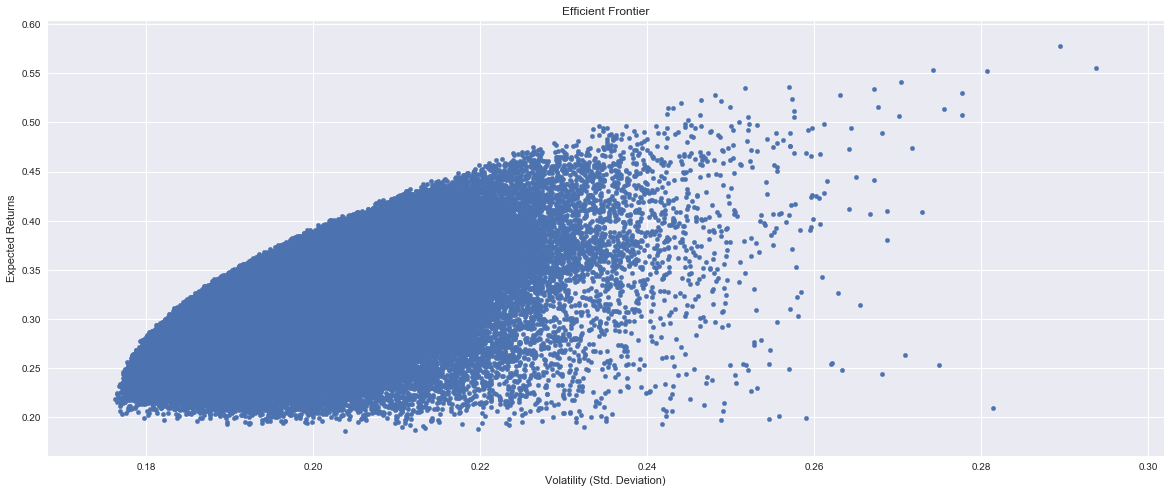

In [3]:
# original plot
# plot the efficient frontier with a scatter plot
plt.style.use('seaborn')
df.plot.scatter(x='Volatility', y='Returns', figsize=(20, 8), grid=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

Text(0.5, 1.0, 'Efficient Frontier')

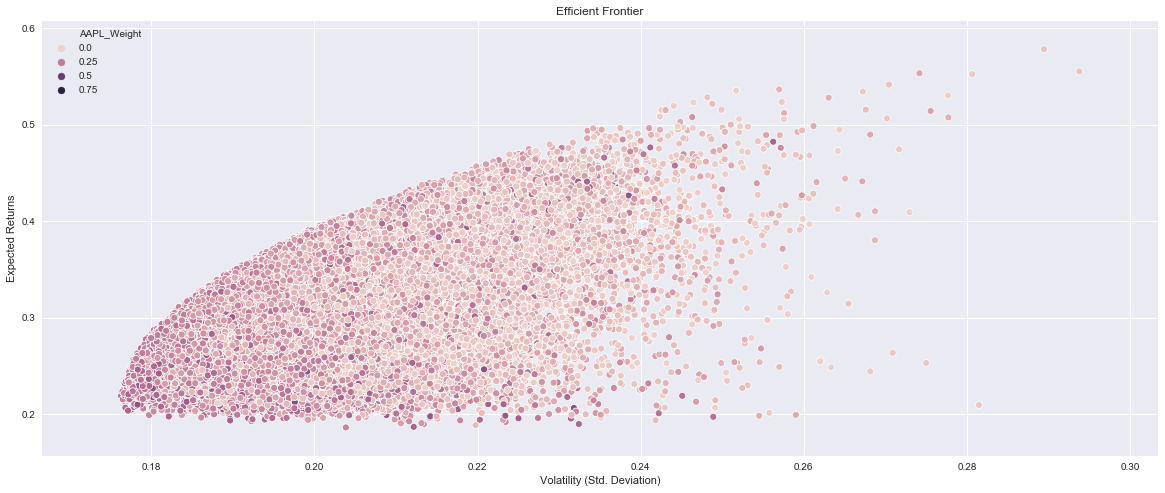

In [4]:
#updated plot - highlighting weight of one stock
# plot the efficient frontier with a scatter plot
fig = plt.figure(figsize=(20,8))
sns.scatterplot(data=df, x="Volatility", y="Returns", hue="AAPL_Weight")
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 9 columns):
Returns        150000 non-null float64
Volatility     150000 non-null float64
AAPL_Weight    150000 non-null float64
AMZN_Weight    150000 non-null float64
FB_Weight      150000 non-null float64
GOOG_Weight    150000 non-null float64
INTC_Weight    150000 non-null float64
NVDA_Weight    150000 non-null float64
TSLA_Weight    150000 non-null float64
dtypes: float64(9)
memory usage: 10.3 MB


In [6]:
df.to_csv('data/quandl_test.csv')

In [7]:
# look at stock price trends
table.head(5)

adj_close                                                       
ticker           AAPL    AMZN      FB    GOOG       INTC       NVDA     TSLA
date                                                                        
2014-06-02  84.529353  308.84  63.080  553.93  24.435452  18.241124  204.700
2014-06-03  85.724718  307.19  62.870  544.94  24.794006  18.164076  204.940
2014-06-04  86.703599  306.78  63.340  544.66  24.740223  18.183338  203.990
2014-06-05  87.043787  323.57  63.186  553.90  24.794006  18.260386  206.900
2014-06-06  86.804445  329.67  62.500  556.33  25.251162  18.327803  208.171

Text(0, 0.5, 'price in $')

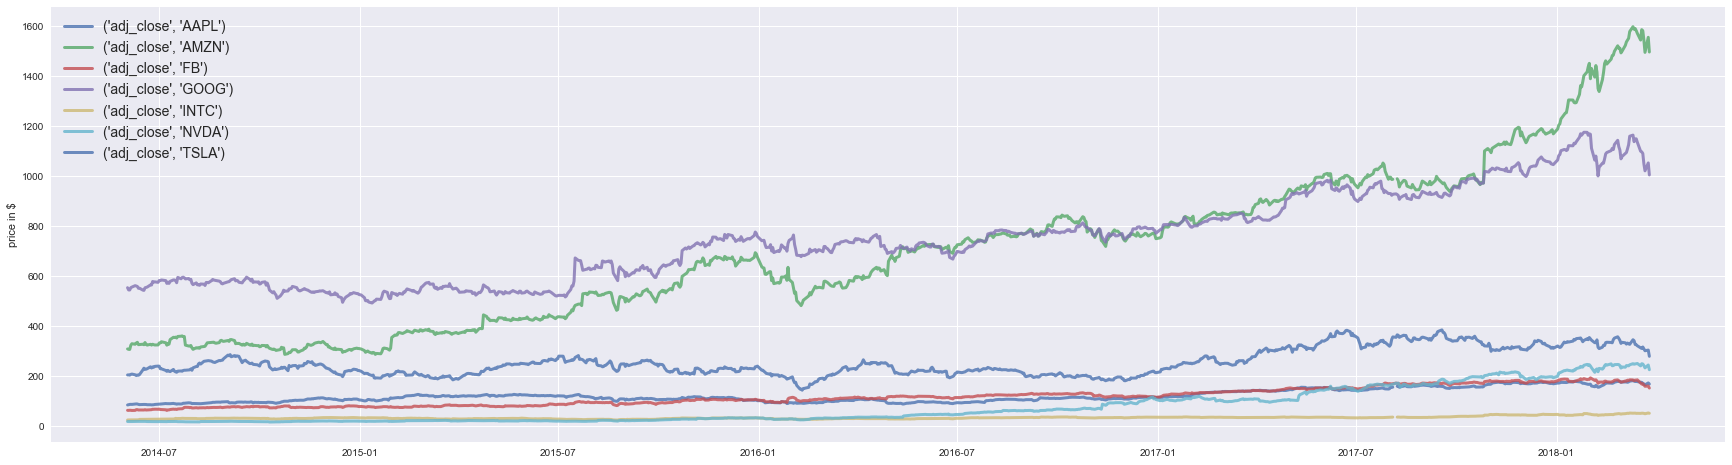

In [8]:
plt.figure(figsize=(30, 8))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=14)
plt.ylabel('price in $')

Text(0, 0.5, 'daily returns')

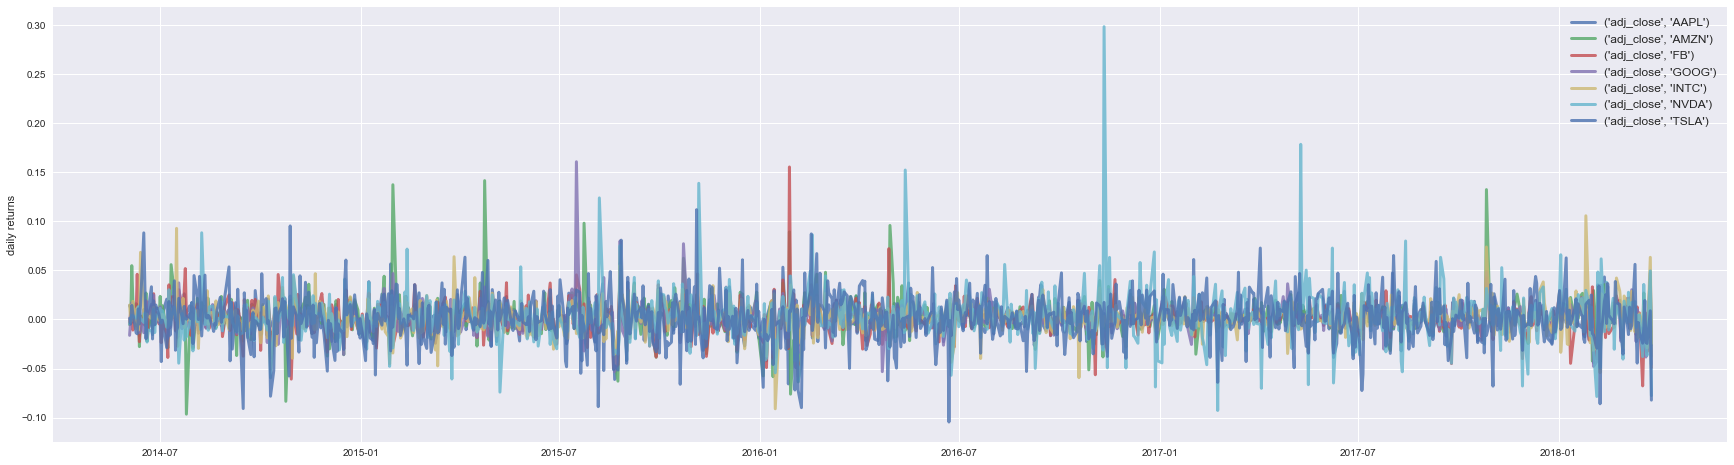

In [9]:
# look at overall % returns by stock
returns = table.pct_change()

plt.figure(figsize=(30, 8))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

In [ ]:
# python magic to store data we have here with other notebooks
%store table